# Shot by Shot Decision Tree Model

In [194]:
# Importing Relevant Libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import random
import math

## Reading in data

In [195]:
shot_data = pd.read_csv('shot_dataset.csv')
shot_data = shot_data.drop(columns = ['Unnamed: 0'])

In [196]:
print(shot_data)

         SHOT_MADE  SHOT_TYPE  LOC_X  LOC_Y  SHOT_DISTANCE  MINS_LEFT  \
0                1          0   23.4  12.95             24         11   
1                1          1   -1.3   5.25              1         10   
2                0          1   -2.2   6.95              2          8   
3                1          0   19.7  20.55             24          7   
4                1          0   -8.3  29.85             25          7   
...            ...        ...    ...    ...            ...        ...   
2947516          1          1   -0.0   5.25              0         11   
2947517          1          1   -0.0   5.25              0         11   
2947518          1          1   -0.0   5.25              0         11   
2947519          1          1   14.3  11.35             15         11   
2947520          1          1   11.3   7.55             11         11   

         SECS_LEFT    MP    FG%    3P%  ...  Reverse Slam Dunk Shot  \
0               20  36.0  0.451  0.300  ...         

In [197]:
print(shot_data.columns)

Index(['SHOT_MADE', 'SHOT_TYPE', 'LOC_X', 'LOC_Y', 'SHOT_DISTANCE',
       'MINS_LEFT', 'SECS_LEFT', 'MP', 'FG%', '3P%', '2P%', 'eFG%', 'Season',
       'DEF_RTG', 'Jump Shot', 'Running Finger Roll Layup Shot',
       'Driving Layup Shot', 'Pullup Jump shot',
       'Driving Finger Roll Layup Shot', 'Tip Layup Shot',
       'Step Back Jump shot', 'Driving Reverse Layup Shot',
       'Running Reverse Layup Shot', 'Layup Shot', 'Running Pull-Up Jump Shot',
       'Dunk Shot', 'Reverse Layup Shot', 'Running Dunk Shot',
       'Floating Jump shot', 'Driving Floating Jump Shot',
       'Cutting Layup Shot', 'Putback Layup Shot', 'Turnaround Jump Shot',
       'Turnaround Fadeaway shot', 'Running Jump Shot', 'Cutting Dunk Shot',
       'Turnaround Hook Shot', 'Running Layup Shot', 'Driving Dunk Shot',
       'Fadeaway Jump Shot', 'Cutting Finger Roll Layup Shot',
       'Running Alley Oop Layup Shot', 'Driving Floating Bank Jump Shot',
       'Running Alley Oop Dunk Shot', 'Driving Hook Shot

In [198]:
shot_data['Season'] = shot_data['Season'].astype(int)
print(type(shot_data['Season'][0]))

<class 'numpy.int64'>


In [199]:
print(shot_data['Season'].unique())

[2021 2020 2019 2018 2017 2016 2015 2014 2013 2012 2011 2010 2009 2008
 2007 2006 2005 2004]


In [200]:
# Naive Value
naive = 0.5442256065351188

## Subsetting data by year for training

In [201]:
data_4 = shot_data[shot_data['Season'] == 2004]
data_5 = shot_data[shot_data['Season'] == 2005]

## Only using one feature (distance)

In [202]:
dist_Xtrain = pd.DataFrame(data_4['SHOT_DISTANCE'])
dist_features = dist_Xtrain.columns

dist_Xtrain = np.array(data_4['SHOT_DISTANCE']).reshape(-1,1)
dist_Ytrain = np.array(data_4['SHOT_MADE'])


dist_Xval = np.array(data_5['SHOT_DISTANCE']).reshape(-1,1)
dist_Yval = np.array(data_5['SHOT_MADE'])

## Decision Tree with only distance feature

In [203]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

dist_tree = DecisionTreeClassifier(random_state = 1)
tree_para = {'max_leaf_nodes':np.arange(2,33),
             'max_features': ['sqrt', 'log2', None],
             'criterion': ['gini', 'entropy', 'log_loss'],
             'ccp_alpha': [0.001,0.01, 0.1, 1]}


dist_tree_search = RandomizedSearchCV(dist_tree, tree_para, scoring ='accuracy', random_state = 1, n_jobs = 4, n_iter = 4)
dist_tree_search.fit(dist_Xtrain, dist_Ytrain)
print(dist_tree_search.best_params_)
print(dist_tree_search.best_score_)

{'max_leaf_nodes': 20, 'max_features': 'log2', 'criterion': 'log_loss', 'ccp_alpha': 0.001}
0.6085606954569327


In [204]:
leafterm = dist_tree_search.best_params_['max_leaf_nodes']
featureterm = dist_tree_search.best_params_['max_features']
critterm = dist_tree_search.best_params_['criterion']
alphaterm = dist_tree_search.best_params_['ccp_alpha']

dist_tree = DecisionTreeClassifier(random_state = 1, max_leaf_nodes = leafterm, max_features = featureterm, 
                                   criterion = critterm, ccp_alpha = alphaterm)

dist_tree.fit(dist_Xtrain, dist_Ytrain)
dist_tree_train = dist_tree.score(dist_Xtrain, dist_Ytrain)
dist_tree_val = dist_tree.score(dist_Xval, dist_Yval)

print(f'The training accuracy is {dist_tree_train}')
print(f'The validation accuracy is {dist_tree_val}')

The training accuracy is 0.6085607319465856
The validation accuracy is 0.6103514189089839


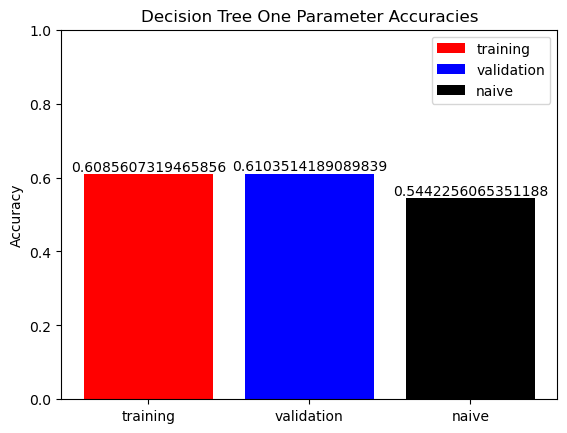

In [205]:
fig, ax = plt.subplots()

group = ['training', 'validation', 'naive']
counts = [dist_tree_train, dist_tree_val, naive]

ax.bar(group, counts, label=group, color = ['red', 'blue', 'black'])

ax.set_ylabel('Accuracy')
ax.set_title('Decision Tree One Parameter Accuracies')
ax.set_ylim([0, 1])

for i in range(len(counts)):
    plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom')
    
ax.legend()
plt.show()

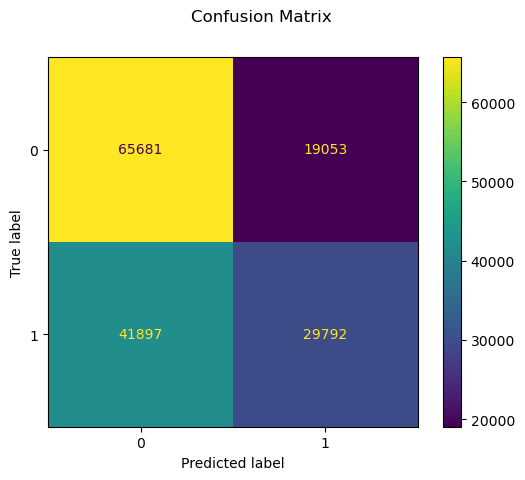

In [206]:
from sklearn import metrics
# Confusion matrix 
dist_tree_pred = dist_tree.predict(dist_Xval)
confusion_dist_tree = metrics.ConfusionMatrixDisplay.from_predictions(dist_Yval, dist_tree_pred, 
                                                                     values_format = '')
confusion_dist_tree.figure_.suptitle("Confusion Matrix")
plt.show()

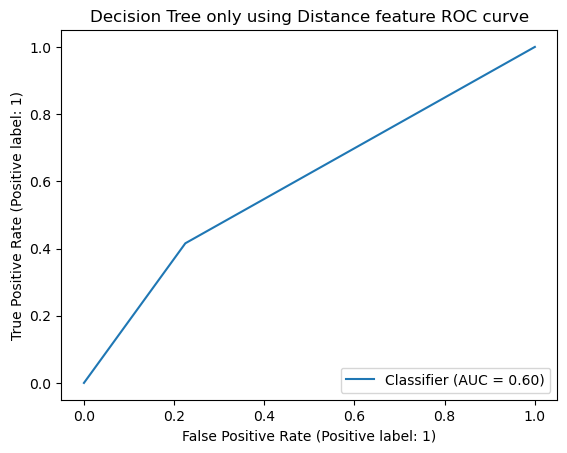

In [207]:
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import RocCurveDisplay

# Decision Tree
RocCurveDisplay.from_predictions(dist_Yval, dist_tree_pred)
plt.title('Decision Tree only using Distance feature ROC curve')
plt.show()

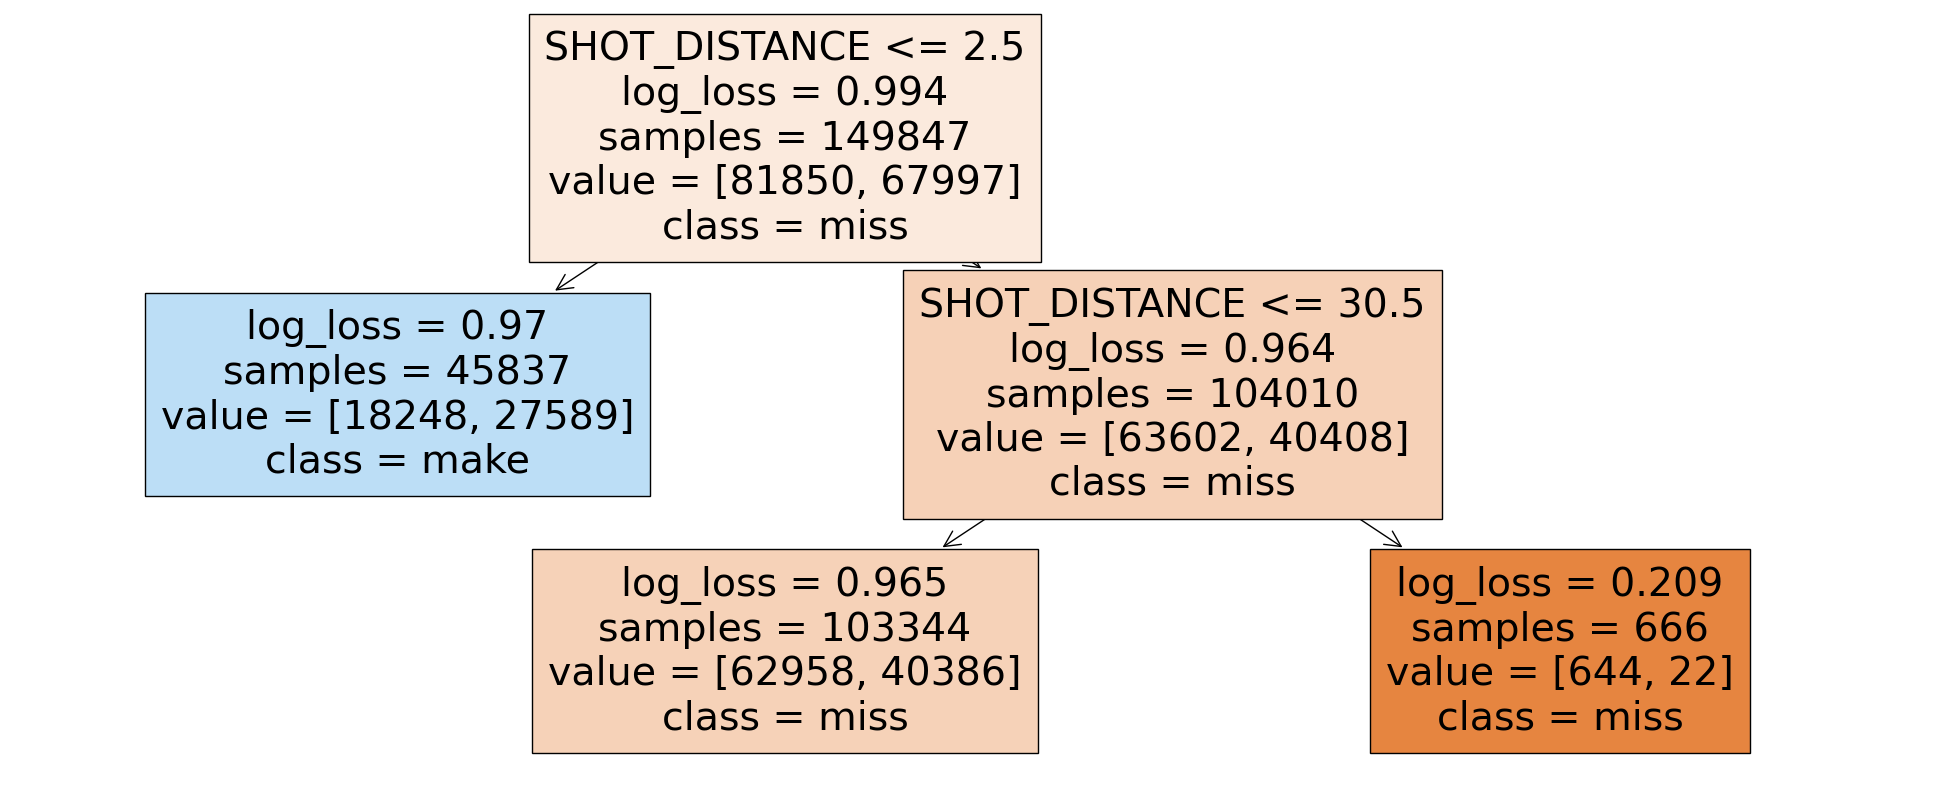

In [208]:
# Visualization of Decision Tree
from sklearn import tree
plt.figure(figsize=(25,10))
tree.plot_tree(dist_tree, feature_names = dist_features, class_names = ['miss', 'make'], filled = True)
plt.show()

## Decision Tree using all features

In [209]:
Xtrain = data_4.drop(columns = ['SHOT_MADE'])
tree_features = Xtrain.columns

Xtrain = np.array(data_4.drop(columns = ['SHOT_MADE']))
Ytrain = np.array(data_4['SHOT_MADE'])

Xval = np.array(data_5.drop(columns = ['SHOT_MADE']))
Yval = np.array(data_5['SHOT_MADE'])

In [210]:
tree_model = DecisionTreeClassifier(random_state = 1)

tree_search = RandomizedSearchCV(tree_model, tree_para, scoring ='accuracy', random_state = 1, n_jobs = 4, n_iter = 4)
tree_search.fit(Xtrain, Ytrain)
print(tree_search.best_params_)
print(tree_search.best_score_)

{'max_leaf_nodes': 20, 'max_features': 'log2', 'criterion': 'log_loss', 'ccp_alpha': 0.001}
0.6113636149413119


In [211]:
leafterm = tree_search.best_params_['max_leaf_nodes']
featureterm = tree_search.best_params_['max_features']
critterm = tree_search.best_params_['criterion']
alphaterm = tree_search.best_params_['ccp_alpha']

tree_model = DecisionTreeClassifier(random_state = 1, max_leaf_nodes = leafterm, max_features = featureterm, 
                                   criterion = critterm, ccp_alpha = alphaterm)

tree_model.fit(Xtrain, Ytrain)
tree_train = tree_model.score(Xtrain, Ytrain)
tree_val = tree_model.score(Xval, Yval)

print(f'The training accuracy is {tree_train}')
print(f'The validation accuracy is {tree_val}')

The training accuracy is 0.6064719347067342
The validation accuracy is 0.607020706673571


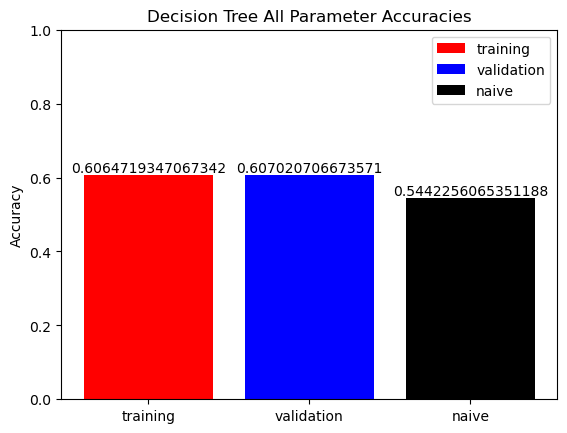

In [212]:
fig, ax = plt.subplots()

group = ['training', 'validation', 'naive']
counts = [tree_train, tree_val, naive]

ax.bar(group, counts, label=group, color = ['red', 'blue', 'black'])

ax.set_ylabel('Accuracy')
ax.set_title('Decision Tree All Parameter Accuracies')
ax.set_ylim([0, 1])

for i in range(len(counts)):
    plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom')
    
ax.legend()
plt.show()

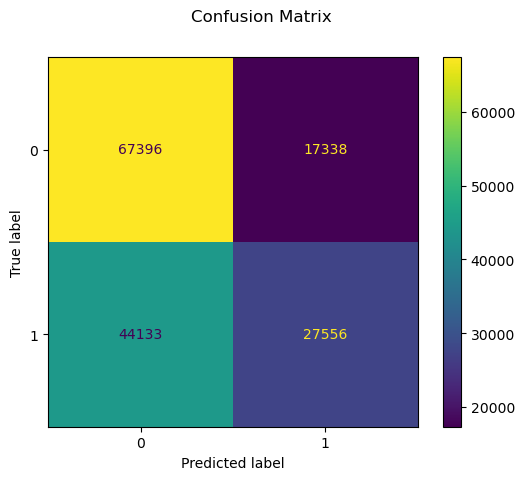

In [213]:
# Confusion matrix 
tree_pred = tree_model.predict(Xval)
confusion_tree = metrics.ConfusionMatrixDisplay.from_predictions(Yval, tree_pred, 
                                                                     values_format = '')
confusion_tree.figure_.suptitle("Confusion Matrix")
plt.show()

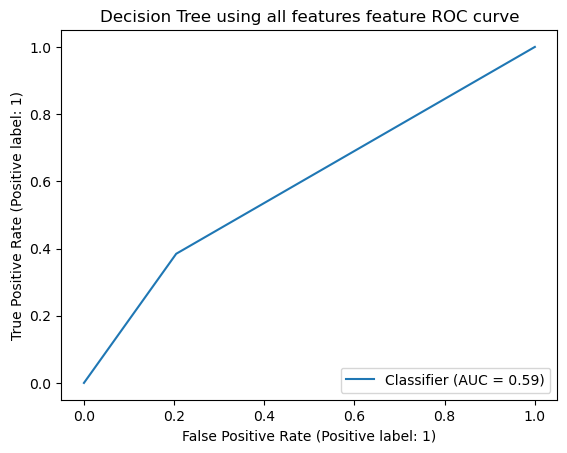

In [214]:
# Decision Tree
RocCurveDisplay.from_predictions(Yval, tree_pred)
plt.title('Decision Tree using all features feature ROC curve')
plt.show()

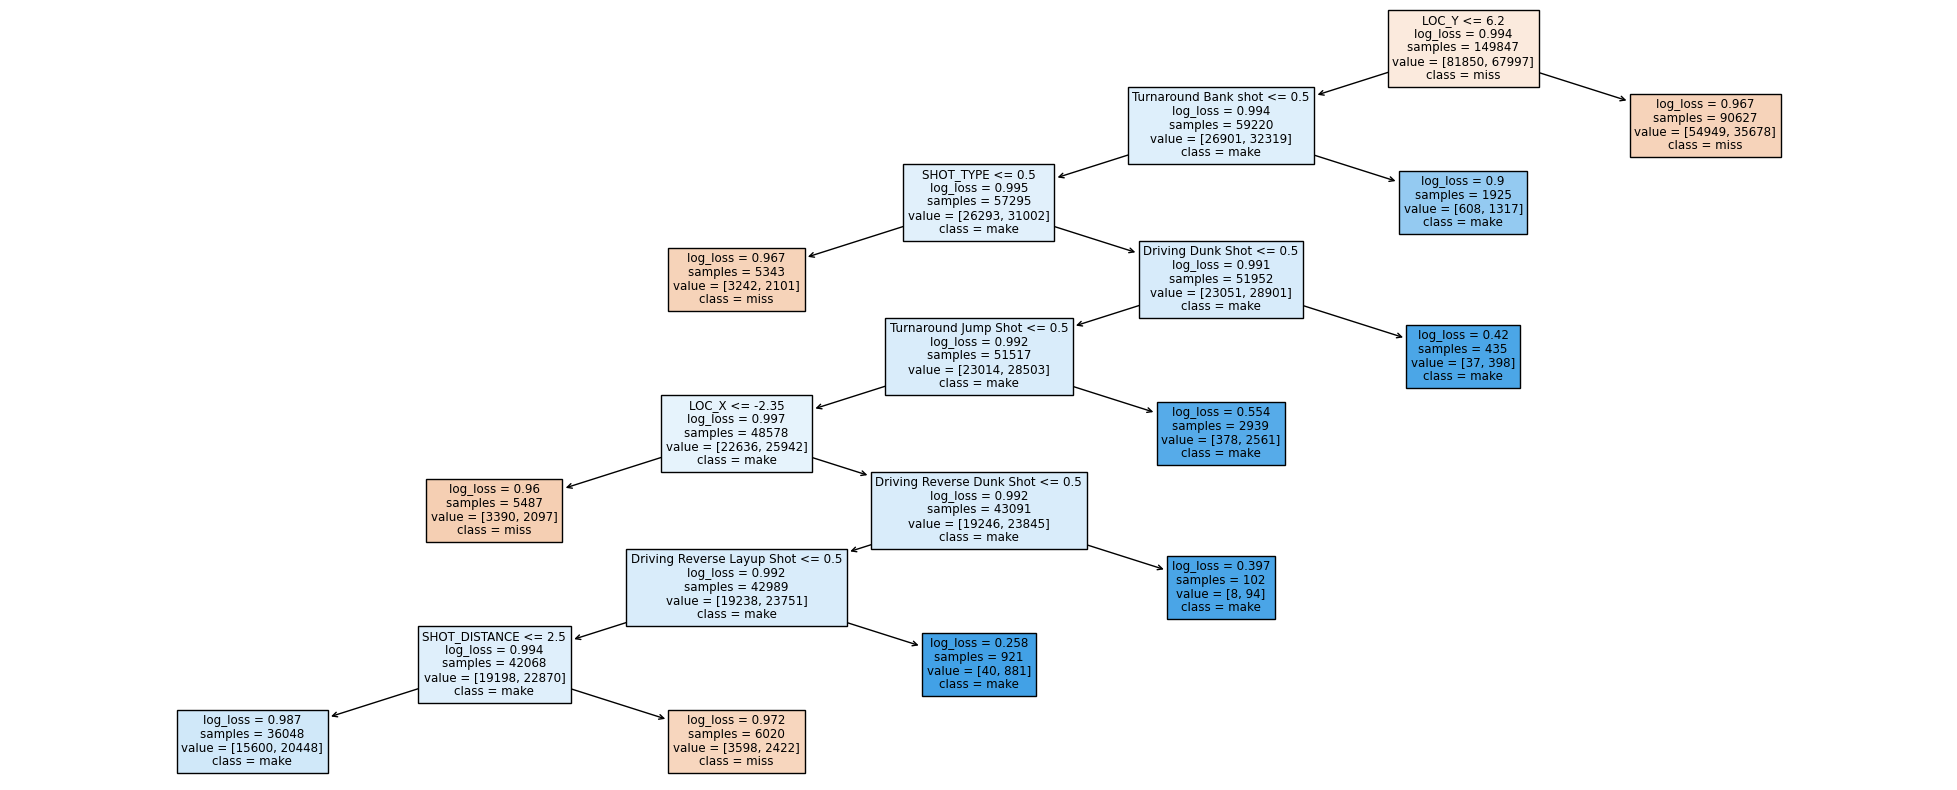

In [215]:
# Visualization of Decision Tree
from sklearn import tree
plt.figure(figsize=(25,10))
tree.plot_tree(tree_model, feature_names = tree_features, class_names = ['miss', 'make'], filled = True)
plt.show()

## Expanding the range of data 
#### TRAINING FROM 2004-2005
#### VALIDATION FROM 2006-2007

In [216]:
train_data = shot_data[(shot_data['Season'] >= 2004) & (shot_data['Season'] <= 2005)]
val_data = shot_data[(shot_data['Season'] >= 2006) & (shot_data['Season'] <= 2007)]

In [217]:
Xtrain = np.array(train_data.drop(columns = ['SHOT_MADE']))
Ytrain = np.array(train_data['SHOT_MADE'])

Xval = np.array(val_data.drop(columns = ['SHOT_MADE']))
Yval = np.array(val_data['SHOT_MADE'])

In [218]:
tree_model = DecisionTreeClassifier(random_state = 1)

tree_search = RandomizedSearchCV(tree_model, tree_para, scoring ='accuracy', random_state = 1, n_jobs = 4, n_iter = 4)
tree_search.fit(Xtrain, Ytrain)
print(tree_search.best_params_)
print(tree_search.best_score_)

{'max_leaf_nodes': 20, 'max_features': 'log2', 'criterion': 'log_loss', 'ccp_alpha': 0.001}
0.6112090638978679


In [219]:
leafterm = tree_search.best_params_['max_leaf_nodes']
featureterm = tree_search.best_params_['max_features']
critterm = tree_search.best_params_['criterion']
alphaterm = tree_search.best_params_['ccp_alpha']

tree_model = DecisionTreeClassifier(random_state = 1, max_leaf_nodes = leafterm, max_features = featureterm, 
                                   criterion = critterm, ccp_alpha = alphaterm)

tree_model.fit(Xtrain, Ytrain)
tree_train = tree_model.score(Xtrain, Ytrain)
tree_val = tree_model.score(Xval, Yval)

print(f'The training accuracy is {tree_train}')
print(f'The validation accuracy is {tree_val}')

The training accuracy is 0.6086851470924348
The validation accuracy is 0.6065069958634283


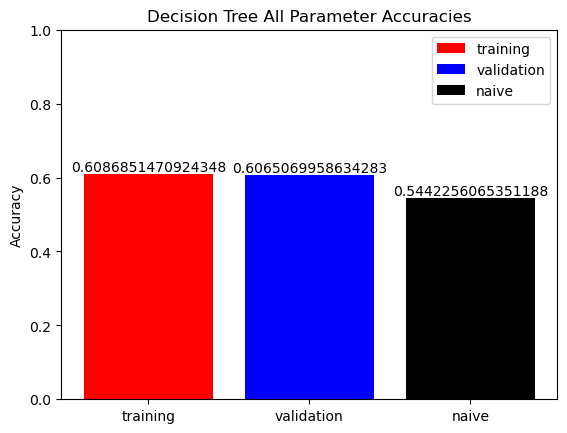

In [220]:
fig, ax = plt.subplots()

group = ['training', 'validation', 'naive']
counts = [tree_train, tree_val, naive]

ax.bar(group, counts, label=group, color = ['red', 'blue', 'black'])

ax.set_ylabel('Accuracy')
ax.set_title('Decision Tree All Parameter Accuracies')
ax.set_ylim([0, 1])

for i in range(len(counts)):
    plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom')
    
ax.legend()
plt.show()

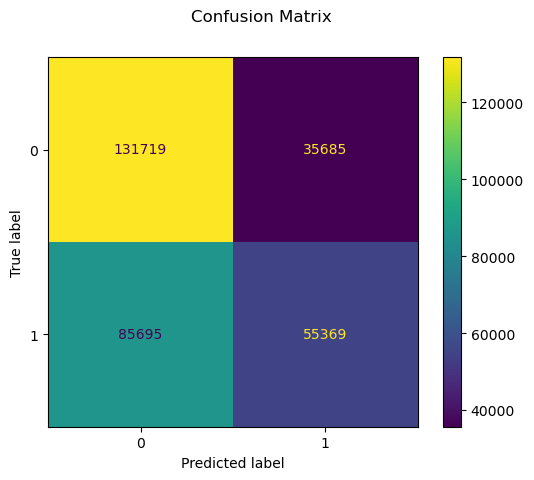

In [221]:
# Confusion matrix 
tree_pred = tree_model.predict(Xval)
confusion_tree = metrics.ConfusionMatrixDisplay.from_predictions(Yval, tree_pred, 
                                                                     values_format = '')
confusion_tree.figure_.suptitle("Confusion Matrix")
plt.show()

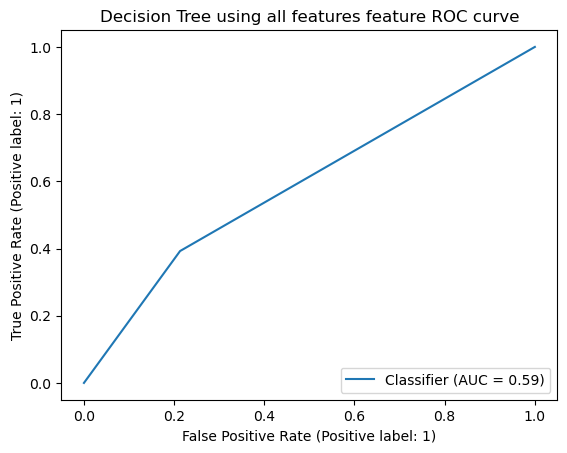

In [222]:
# Decision Tree
RocCurveDisplay.from_predictions(Yval, tree_pred)
plt.title('Decision Tree using all features feature ROC curve')
plt.show()

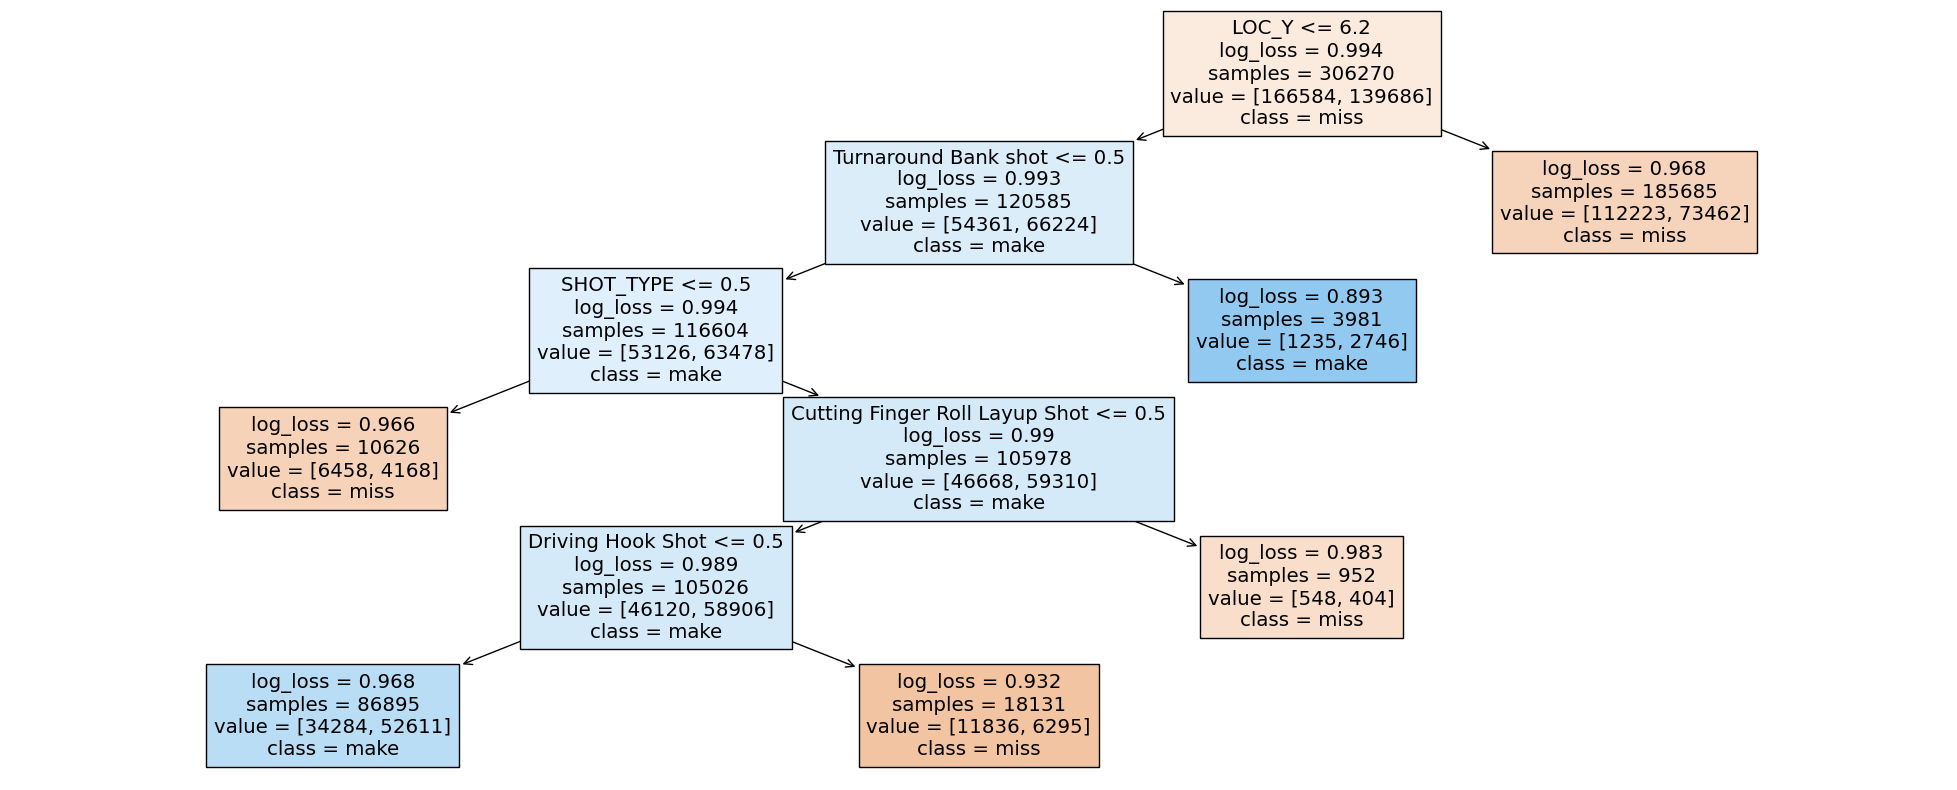

In [223]:
# Visualization of Decision Tree
from sklearn import tree
plt.figure(figsize=(25,10))
tree.plot_tree(tree_model, feature_names = tree_features, class_names = ['miss', 'make'], filled = True)
plt.show()

## Expanding the range of data 
#### TRAINING FROM 2004-2007
#### VALIDATION FROM 2008-2011

In [224]:
train_data = shot_data[(shot_data['Season'] >= 2004) & (shot_data['Season'] <= 2007)]
val_data = shot_data[(shot_data['Season'] >= 2008) & (shot_data['Season'] <= 2011)]

In [225]:
Xtrain = np.array(train_data.drop(columns = ['SHOT_MADE']))
Ytrain = np.array(train_data['SHOT_MADE'])

Xval = np.array(val_data.drop(columns = ['SHOT_MADE']))
Yval = np.array(val_data['SHOT_MADE'])

In [226]:
tree_model = DecisionTreeClassifier(random_state = 1)

tree_search = RandomizedSearchCV(tree_model, tree_para, scoring ='accuracy', random_state = 1, n_jobs = 4, n_iter = 4)
tree_search.fit(Xtrain, Ytrain)
print(tree_search.best_params_)
print(tree_search.best_score_)

{'max_leaf_nodes': 20, 'max_features': 'log2', 'criterion': 'log_loss', 'ccp_alpha': 0.001}
0.6123665555147231


In [227]:
leafterm = tree_search.best_params_['max_leaf_nodes']
featureterm = tree_search.best_params_['max_features']
critterm = tree_search.best_params_['criterion']
alphaterm = tree_search.best_params_['ccp_alpha']

tree_model = DecisionTreeClassifier(random_state = 1, max_leaf_nodes = leafterm, max_features = featureterm, 
                                   criterion = critterm, ccp_alpha = alphaterm)

tree_model.fit(Xtrain, Ytrain)
tree_train = tree_model.score(Xtrain, Ytrain)
tree_val = tree_model.score(Xval, Yval)

print(f'The training accuracy is {tree_train}')
print(f'The validation accuracy is {tree_val}')

The training accuracy is 0.6059182936470496
The validation accuracy is 0.610800818189125


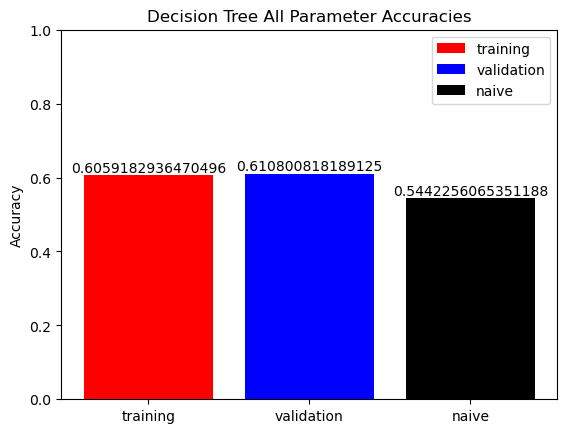

In [228]:
fig, ax = plt.subplots()

group = ['training', 'validation', 'naive']
counts = [tree_train, tree_val, naive]

ax.bar(group, counts, label=group, color = ['red', 'blue', 'black'])

ax.set_ylabel('Accuracy')
ax.set_title('Decision Tree All Parameter Accuracies')
ax.set_ylim([0, 1])

for i in range(len(counts)):
    plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom')
    
ax.legend()
plt.show()

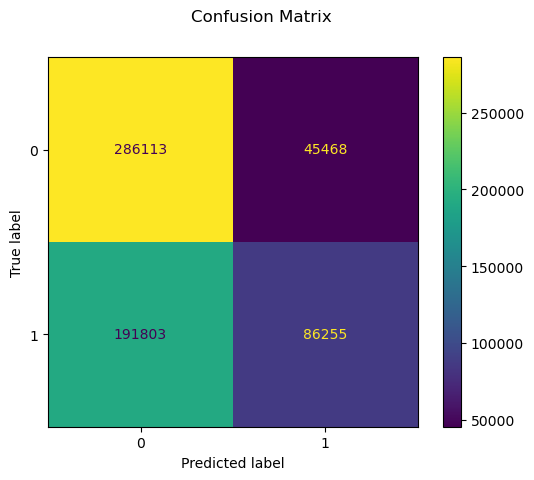

In [229]:
# Confusion matrix 
tree_pred = tree_model.predict(Xval)
confusion_tree = metrics.ConfusionMatrixDisplay.from_predictions(Yval, tree_pred, 
                                                                     values_format = '')
confusion_tree.figure_.suptitle("Confusion Matrix")
plt.show()

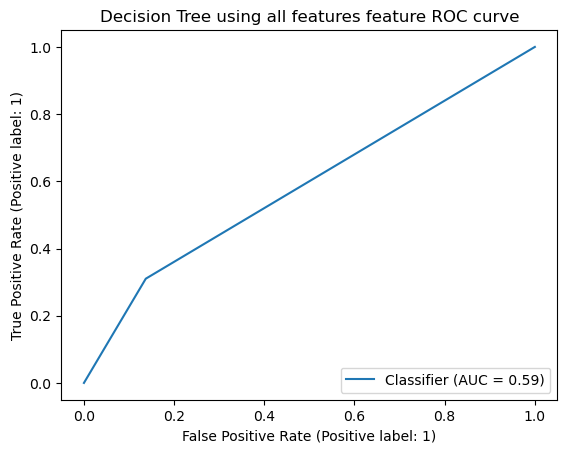

In [230]:
# Decision Tree
RocCurveDisplay.from_predictions(Yval, tree_pred)
plt.title('Decision Tree using all features feature ROC curve')
plt.show()

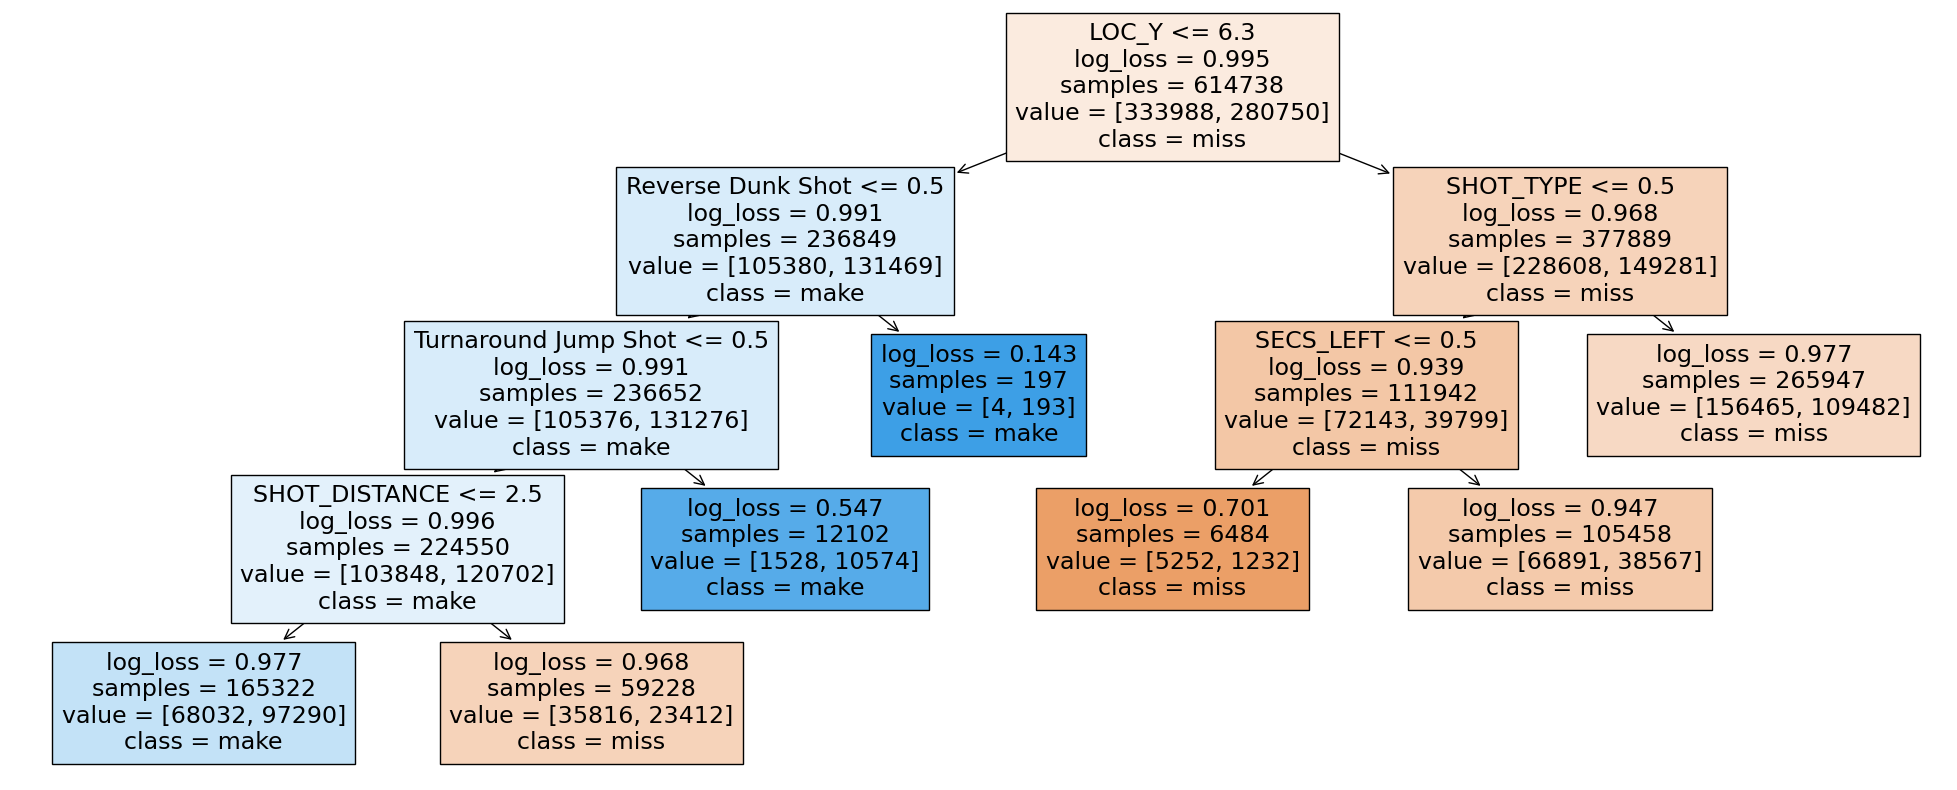

In [231]:
# Visualization of Decision Tree
from sklearn import tree
plt.figure(figsize=(25,10))
tree.plot_tree(tree_model, feature_names = tree_features, class_names = ['miss', 'make'], filled = True)
plt.show()

It seems that the model consistantly uses the parameters {'max_leaf_nodes': 20, 'max_features': 'log2', 'criterion': 'log_loss', 'ccp_alpha': 0.001} so we will use this for the final testing

## Final Testing and Results

In [232]:
train_data = shot_data[(shot_data['Season'] >= 2004) & (shot_data['Season'] <= 2017)]
test_data = shot_data[(shot_data['Season'] >= 2018)]

In [233]:
Xtrain = np.array(train_data.drop(columns = ['SHOT_MADE']))
Ytrain = np.array(train_data['SHOT_MADE'])

Xtest = np.array(test_data.drop(columns = ['SHOT_MADE']))
Ytest = np.array(test_data['SHOT_MADE'])

In [234]:
tree_model = DecisionTreeClassifier(random_state = 1, max_leaf_nodes = 20, max_features = 'log2', 
                                   criterion = 'log_loss', ccp_alpha = 0.001)

tree_model.fit(Xtrain, Ytrain)
tree_train = tree_model.score(Xtrain, Ytrain)
tree_test = tree_model.score(Xtest, Ytest)

print(f'The training accuracy is {tree_train}')
print(f'The validation accuracy is {tree_test}')

The training accuracy is 0.6222158616324366
The validation accuracy is 0.5946224289768571


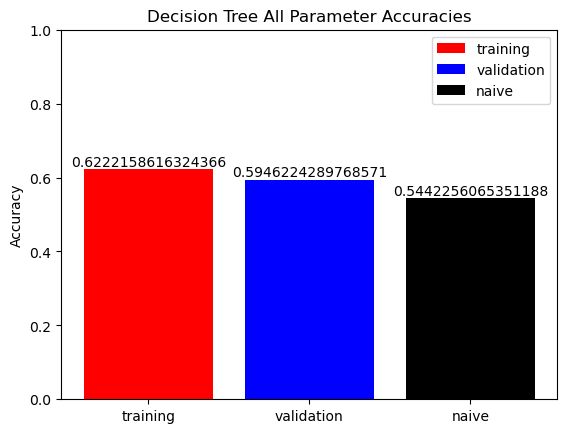

In [235]:
fig, ax = plt.subplots()

group = ['training', 'validation', 'naive']
counts = [tree_train, tree_test, naive]

ax.bar(group, counts, label=group, color = ['red', 'blue', 'black'])

ax.set_ylabel('Accuracy')
ax.set_title('Decision Tree All Parameter Accuracies')
ax.set_ylim([0, 1])

for i in range(len(counts)):
    plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom')
    
ax.legend()
plt.show()

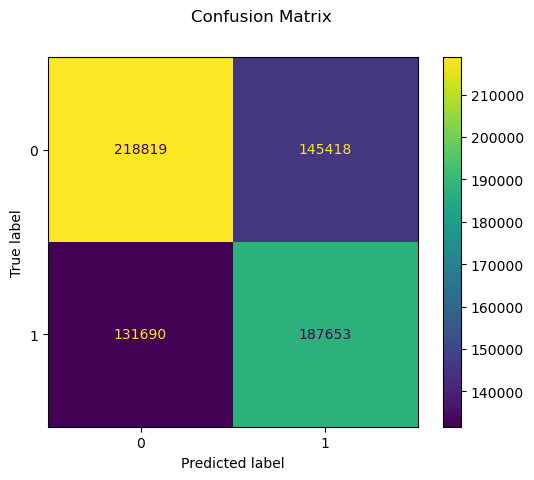

In [236]:
# Confusion matrix 
tree_pred = tree_model.predict(Xtest)
confusion_tree = metrics.ConfusionMatrixDisplay.from_predictions(Ytest, tree_pred, 
                                                                     values_format = '')
confusion_tree.figure_.suptitle("Confusion Matrix")
plt.show()

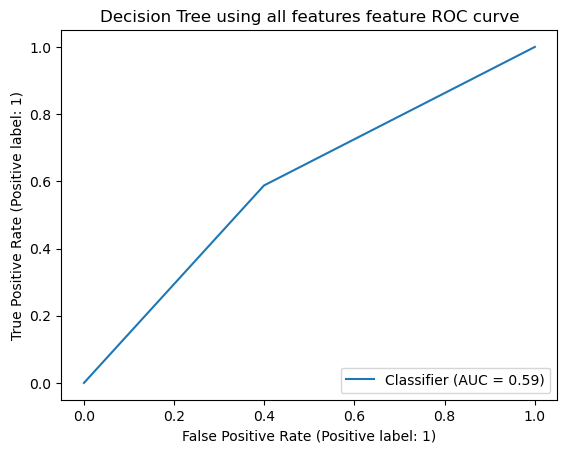

In [237]:
# Decision Tree
RocCurveDisplay.from_predictions(Ytest, tree_pred)
plt.title('Decision Tree using all features feature ROC curve')
plt.show()

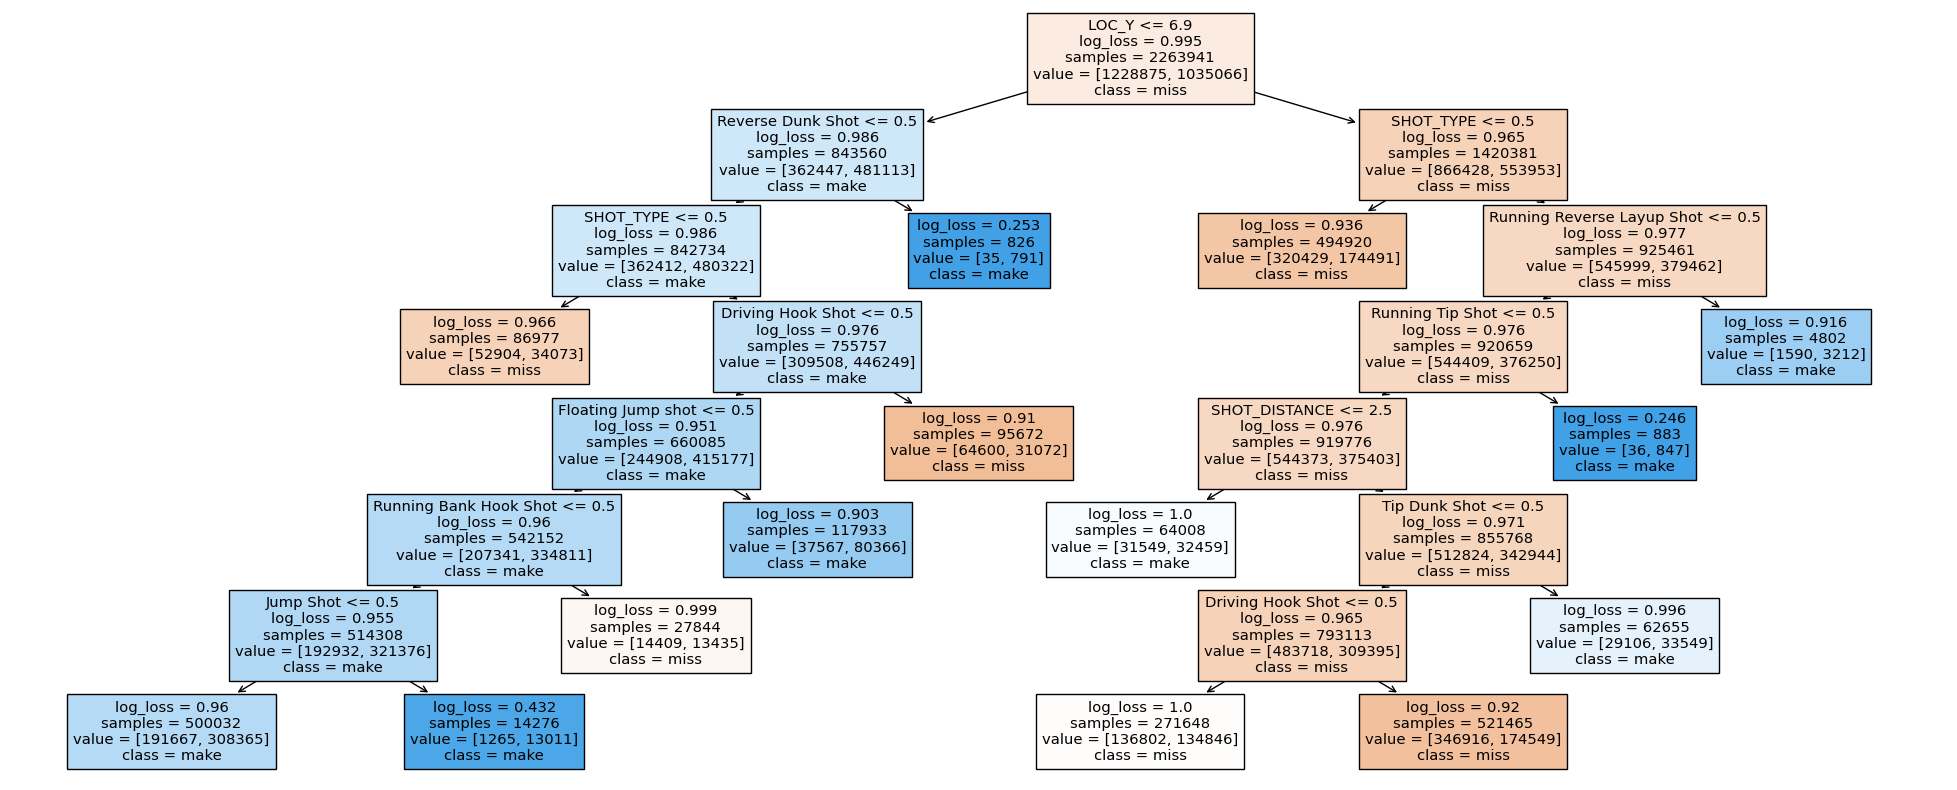

In [238]:
# Visualization of Decision Tree
from sklearn import tree
plt.figure(figsize=(25,10))
tree.plot_tree(tree_model, feature_names = tree_features, class_names = ['miss', 'make'], filled = True)
plt.show()

In [239]:
feature_imp = tree_model.feature_importances_.reshape(-1,1)
feature_df = pd.DataFrame(feature_imp, index = tree_features, columns = ['Feature_Val'])

In [240]:
sorted_df = feature_df.sort_values(by=['Feature_Val'], ascending = False)

In [241]:
top_20 = sorted_df.head(20)

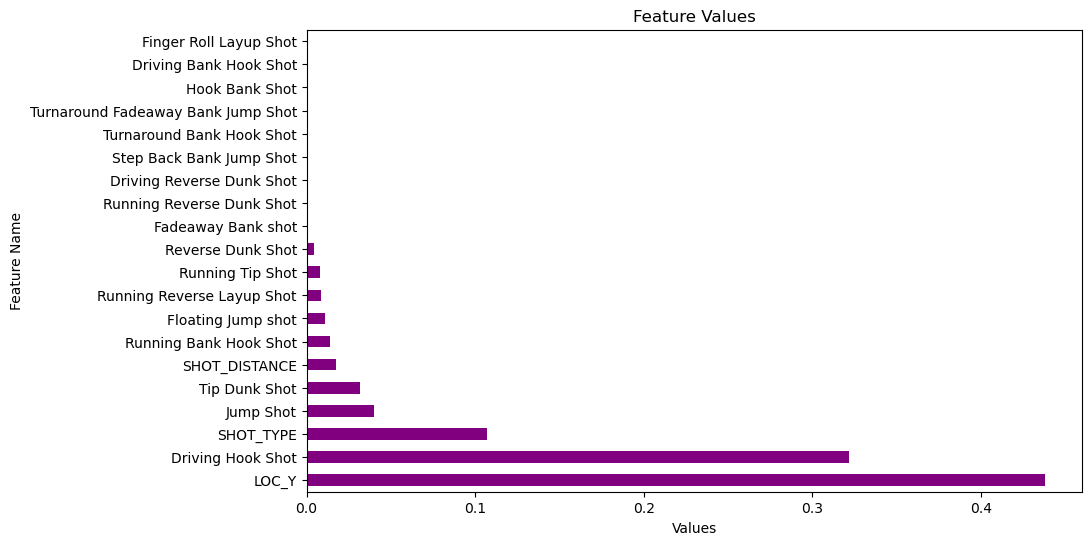

In [242]:
top_20['Feature_Val'].plot(kind='barh', figsize=(10, 6), color = 'purple')

plt.xlabel('Values')
plt.ylabel('Feature Name')
plt.title('Feature Values')
plt.show()